In [ ]:
!pip install langchain langgraph langchain-community langchain-text-splitters langchain-groq langchain-huggingface langchain-chroma pymupdf arxiv sentence-transformers

In [ ]:
from google.colab import userdata
import os
os.environ['GROQ_API_KEY'] = userdata.get('GROQ_API_KEY')
os.environ['HF_TOKEN'] = userdata.get('HF_TOKEN')

In [ ]:
from langchain_community.document_loaders import WebBaseLoader
def load_docs():
    urls = [
        "https://python.langchain.com/docs/concepts/",
        "https://python.langchain.com/docs/tutorials/",
        "https://python.langchain.com/docs/how_to/"
    ]
    docs = []
    for url in urls:
        loader = WebBaseLoader(url)
        docs.extend(loader.load())
    return docs

docs = load_docs()

In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200
)
doc_splits = text_splitter.split_documents(docs)

In [ ]:
from langchain_huggingface import HuggingFaceEmbeddings
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
from langchain_chroma import Chroma
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    embedding=embeddings,
    persist_directory="./chroma_db"
)

In [ ]:
from langchain.tools.retriever import create_retriever_tool
retriever = vectorstore.as_retriever(search_kwargs={"k": 5})
retriever_tool = create_retriever_tool(
    retriever,
    "document_retriever",
    "Retrieves relevant documents based on the query"
)

In [ ]:
from langchain_groq import ChatGroq
llm = ChatGroq(model_name="openai/gpt-oss-120b", temperature=0)

In [ ]:
from typing import TypedDict, Sequence, Annotated
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langgraph.graph import add_messages

class MetaRAGState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]
    original_query: str
    meta_prompt: str
    refined_query: str
    retrieved_docs: str
    final_response: str

In [ ]:
def meta_prompt_generator(state: MetaRAGState):
    """Agent 1: Generates specialized prompts for different query types"""
    original_query = state["messages"][-1].content if state["messages"] else state.get("original_query", "")

    meta_prompt = f"""
    Analyze this user query and generate an optimized search prompt for document retrieval.

    User Query: {original_query}

    Consider:
    1. Key concepts and technical terms
    2. Context needed for accurate retrieval
    3. Specific domains or topics involved

    Generate a focused, keyword-rich search query:
    """

    response = llm.invoke([HumanMessage(content=meta_prompt)])
    refined_query = response.content.strip()

    return {
        "messages": [AIMessage(content=f"Meta-prompt generated refined query: {refined_query}")],
        "meta_prompt": meta_prompt,
        "refined_query": refined_query,
        "original_query": original_query
    }

In [ ]:
def retrieval_agent(state: MetaRAGState):
    """Agent 2: Uses the refined query to retrieve relevant documents"""
    refined_query = state["refined_query"]

    retrieved_docs = retriever_tool.invoke({"query": refined_query})

    return {
        "messages": [AIMessage(content="Documents retrieved successfully")],
        "retrieved_docs": retrieved_docs
    }

In [ ]:
def response_generator(state: MetaRAGState):
    """Agent 3: Generates final response using original query and retrieved docs"""
    original_query = state["original_query"]
    retrieved_docs = state["retrieved_docs"]

    response_prompt = f"""
    Based on the retrieved documents, provide a comprehensive answer to the user's question.

    User Question: {original_query}

    Retrieved Context: {retrieved_docs}

    Instructions:
    - Answer directly and accurately
    - Use information from the retrieved documents
    - If the documents don't contain relevant information, state that clearly
    - Keep the response focused and helpful

    Answer:
    """

    final_response = llm.invoke([HumanMessage(content=response_prompt)])

    return {
        "messages": [AIMessage(content=final_response.content)],
        "final_response": final_response.content
    }

In [ ]:
from langgraph.graph import StateGraph, START, END, add_messages

workflow = StateGraph(MetaRAGState)

workflow.add_node("meta_prompt_generator", meta_prompt_generator)
workflow.add_node("retrieval_agent", retrieval_agent)
workflow.add_node("response_generator", response_generator)

workflow.add_edge(START, "meta_prompt_generator")
workflow.add_edge("meta_prompt_generator", "retrieval_agent")
workflow.add_edge("retrieval_agent", "response_generator")
workflow.add_edge("response_generator", END)

app = workflow.compile()

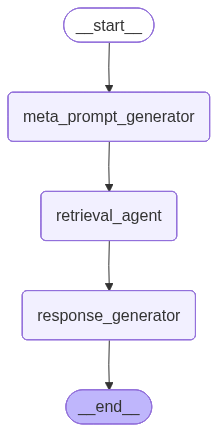

In [ ]:
app

In [ ]:
def run_meta_rag_agent(query: str):
    """Run the complete meta-prompting RAG workflow"""

    initial_state = {
        "messages": [HumanMessage(content=query)],
        "original_query": query,
        "meta_prompt": "",
        "refined_query": "",
        "retrieved_docs": "",
        "final_response": ""
    }

    print(f"🔍 Processing query: {query}\n")

    for step in app.stream(initial_state):
        for node_name, node_output in step.items():
            print(f"📍 {node_name.upper()}")
            if "meta_prompt" in node_output and node_output["meta_prompt"]:
                print(f"   Meta-prompt created")
            if "refined_query" in node_output and node_output["refined_query"]:
                print(f"   Refined query: {node_output['refined_query']}")
            if "retrieved_docs" in node_output and node_output["retrieved_docs"]:
                print(f"   Retrieved {len(str(node_output['retrieved_docs']))} characters of context")
            if "final_response" in node_output and node_output["final_response"]:
                print(f"   ✅ Final response generated")
            print()

    final_result = app.invoke(initial_state)
    return final_result["final_response"]

test_query = "What are the key concepts in retrieval augmented generation?"
result = run_meta_rag_agent(test_query)

print("🎯 FINAL ANSWER:")
print("=" * 50)
print(result)

🔍 Processing query: What are the key concepts in retrieval augmented generation?

📍 META_PROMPT_GENERATOR
   Meta-prompt created
   Refined query: **Optimized Search Prompt**

```
"retrieval-augmented generation" OR RAG AND (key concepts OR core components) AND (vector store OR vector database OR dense retrieval OR sparse retrieval) AND (large language model OR LLM) AND (knowledge grounding OR external knowledge integration) AND (prompt engineering OR context injection) AND (hybrid search OR multi‑modal retrieval) AND (fine‑tuning OR adapter) AND (open‑domain QA OR summarization OR code generation)
```

📍 RETRIEVAL_AGENT
   Retrieved 4804 characters of context

📍 RESPONSE_GENERATOR
   ✅ Final response generated

🎯 FINAL ANSWER:
**Key concepts in Retrieval‑Augmented Generation (RAG)**  

1. **Embedding models**  
   * Transform raw data (text, images, etc.) into dense vector representations.  
   * These vectors capture semantic meaning and are the basis for similarity search.

2. **Vec